<a href="https://colab.research.google.com/github/utarinw/CelebEndorse/blob/main/Labelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Labelling

Proses pemberian labelling menggunakan algoritma lexicon feature based. Pemberian labelling dilakukan untuk mengklasifikasikan sentimen positif dan negatif berdasarkan kamus lexicon. Adapun pada proses ini menggunakan kamus lexicon merupakan hasil modifikasi dataset yang dilakukan oleh [Evan Martua](https://github.com/evanmartua34/Twitter-COVID19-Indonesia-Sentiment-Analysis---Lexicon-Based) dengan menggabungkan beberapa dasaset yang telah diteliti oleh beberapa penelitian sebelumnya dan dasaset tersebut telah memiliki nilai bobot untuk menentukan label pada lexicon.

## Install Library

In [1]:
# Install Library

! pip install pandas
! pip install sastrawi
! pip install regex
! pip install numpy
! pip install nltk
! pip install swifter
! pip install matplotlib

## Import Library

In [2]:
import pandas as pd
import re
import string 
import numpy as np
import os

# proses stemming
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.tokenize import word_tokenize

import nltk
nltk.download('punkt')

# visualisasi
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Import File

In [5]:
df = pd.read_csv("DatasetLabelling.csv")
df.head(13)

,Dataset Labelling
0,['selebgram']
1,"['lapar', 'makan', 'monyet', 'binatang', 'lara..."
2,"['terguna', 'akun', 'tuyul', 'akun', 'asli', '..."
3,"['ekspresi', 'ya', 'menilai', 'terlambat', 'va..."
4,"['kakak', 'temenin', 'pemotretan', 'yuk', 'kak..."
5,"['mc donalds', 'kolaborasi', 'bts', 'doang', '..."
6,"['permisi', 'kakak', 'menerima', 'tawaran', 'e..."
7,"['berita', 'bicu', 'daya', 'jual', 'produk', '..."
8,"['menyindir', 'orang', 'istilah', 'endorse', '..."
9,"['istora', 'menikmati', 'seburu', 'atmosfer', ..."


## Process Labelling

### Kamus Kata

In [6]:
kamus_kata = {}
for i in range(0,len(df['Dataset Labelling'])):
    kalimat = df['Dataset Labelling'][i]
    kata_token = word_tokenize(kalimat)
    for j in kata_token:
        if j not in kamus_kata:
            kamus_kata[j] = 1
        else:
            kamus_kata[j] += 1

In [7]:
# hitung banyak frekuensi kamus_kata

len(kamus_kata)

8486

In [8]:
len({k:v for (k,v) in kamus_kata.items() if v < 4})

6640

### Import Kamus Lexicon

Import kamus lexicon yang digunakan kemudian menghapus kata berkonotasi negatif dan mengkombinasikan dengan kamus lexicon dengan kata berkonotasi negatif

In [9]:
# Fungsi Sentimen Negatif

negasi = ['bukan','tidak','ga','gk']
lexicon = pd.read_csv("Kamus Lexicon.csv")
lexicon = lexicon.drop(lexicon[(lexicon['word'] == 'bukan')
                               |(lexicon['word'] == 'tidak')
                               |(lexicon['word'] == 'ga')
                               |(lexicon['word'] == 'gk') ].index,axis=0)
lexicon = lexicon.reset_index(drop=True)

In [10]:
len(lexicon)

10256

In [11]:
# Show 10 data teratas dari file csv

lexicon.head(10)

,word,weight,number_of_words
0,aahh,-3,1
1,aamiin,2,1
2,ab,3,1
3,aba,2,1
4,aba-aba,-3,1
5,abadi,4,1
6,abah,3,1
7,abai,-3,1
8,abaikan,-2,1
9,abar-abar,-5,1


In [12]:
# mengubah kamus lexicon ke dalam bentuk list
lexicon_word = lexicon['word'].to_list()
lexicon_num_words = lexicon['number_of_words']

# menampilkan berapa banyak kata yang ada di kamus lexicon
len(lexicon_word)

10256

In [13]:
# fungsi membuat fungsi untuk mengecek kata apakah tersedia dikamus di lexicon

fk_kata = []
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# pengecekan kata dasar dalam kamus lexicon
for word in kamus_kata.keys():
    if word not in lexicon_word:
        kata_dasar = stemmer.stem(word)
        if kata_dasar not in lexicon_word:
            fk_kata.append(word)
            
# menghitung jumlah kata yang termasuk kamus lexicon
len(fk_kata)

5439

In [14]:
# ns_words_list berfungsi untuk penampung mengecek kata

fk_kata_list = {k:v for (k,v) in kamus_kata.items() if ((k in fk_kata)&(v>3))}

In [15]:
# mengurutkan serta menghitung jumlah kata yang tidak terdapat di kamus lexicon

urut_kata = sorted(fk_kata_list.items(), key=lambda x: x[1], reverse=True)
urut_kata = urut_kata[0:24]
for i in urut_kata:
    print(i[0], i[1])

' 52981
, 46881
[ 6100
] 6100
'endorse 4876
'fadiljaidi 831
'ulasan 601
'influencer 581
'kakak 494
'sih 407
'orang 403
'mempromosikan 393
'udah 352
'selebgram 269
'nih 243
'endorsement 238
'story 226
'berpakaian 219
'merek 184
'celebrity 178
'kawan 175
'abang 175
'konten 152
'akun 137


### Matriks Perhitungan Bobot

Menghitung kata dengan jumlah bobot dalam kamus lexicon dan membuat matriks perhitungan bobot

In [16]:
sencol = []
senrow = np.array([])
nsen = 0
factory = StemmerFactory()
stemmer = factory.create_stemmer()
sentiment_list = []

# fungsi pengecekan kata apakah ada didalam kamus
def found_word(ind,words,word,sen,sencol,sentiment,add):
    # Kondisi jika  kata telah termasuk kedalam Bag of Words matrix, lalu dilakukan menambahan nilai
    if word in sencol:
        sen[sencol.index(word)] += 1
    else:
    # kondisi jika tidak, maka kata baru ditambahkan
        sencol.append(word)
        sen.append(1)
        add += 1
    # Kondisi pengecekan negasi, jika terdapat negasi sebelumnya, makanya negasi sebelumnya yang menjadi negasi sentimen
    if (words[ind-1] in negasi):
        sentiment += -lexicon['weight'][lexicon_word.index(word)]
    else:
        sentiment += lexicon['weight'][lexicon_word.index(word)]
    
    return sen,sencol,sentiment,add
            
# memeriksa kata yang muncul dalam kamus leksikon, kemudian akan dihitung nilai bobot sentimen dari kata yang muncul
for i in range(len(df)):
    nsen = senrow.shape[0]
    words = word_tokenize(df['Dataset Labelling'][i])
    sentiment = 0 
    add = 0
    prev = [0 for ii in range(len(words))]
    n_words = len(words)
    if len(sencol)>0:
        sen =[0 for j in range(len(sencol))]
    else:
        sen =[]
    
    for word in words:
        ind = words.index(word)
        # pengecekan kata yang termasuk dalam kamus lexicon
        if word in lexicon_word :
            sen,sencol,sentiment,add= found_word(ind,words,word,sen,sencol,sentiment,add)
        else:
        # Jika tidak terdapat, maka akan dilakukan proses stemming
            kata_dasar = stemmer.stem(word)
            if kata_dasar in lexicon_word:
                sen,sencol,sentiment,add= found_word(ind,words,kata_dasar,sen,sencol,sentiment,add)
        # jika masih belum didapatkan, maka akan dicocokkan dengan kombinasi kata terdekat
            elif(n_words>1):
                if ind-1>-1:
                    back_1    = words[ind-1]+' '+word
                    if (back_1 in lexicon_word):
                        sen,sencol,sentiment,add= found_word(ind,words,back_1,sen,sencol,sentiment,add)
                    elif(ind-2>-1):
                        back_2    = words[ind-2]+' '+back_1
                        if back_2 in lexicon_word:
                            sen,sencol,sentiment,add= found_word(ind,words,back_2,sen,sencol,sentiment,add)
    # Jika terdapat kata baru, maka matriks bag of word akan di perluas
    if add>0:  
        if i>0:
            if (nsen==0):
                senrow = np.zeros([i,add],dtype=int)
            elif(i!=nsen):
                padding_h = np.zeros([nsen,add],dtype=int)
                senrow = np.hstack((senrow,padding_h))
                padding_v = np.zeros([(i-nsen),senrow.shape[1]],dtype=int)
                senrow = np.vstack((senrow,padding_v))
            else:
                padding =np.zeros([nsen,add],dtype=int)
                senrow = np.hstack((senrow,padding))
            senrow = np.vstack((senrow,sen))
        if i==0:
            senrow = np.array(sen).reshape(1,len(sen))
    # jika tidak terdapat, maka hanya memperbaru matriks bag of words lama
    elif(nsen>0):
        senrow = np.vstack((senrow,sen))
        
    sentiment_list.append(sentiment)

In [17]:
# membuat dataframe baru

sencol.append('sentiment')
sentiment_array = np.array(sentiment_list).reshape(senrow.shape[0],1)
sentiment_data = np.hstack((senrow,sentiment_array))
df_sen = pd.DataFrame(sentiment_data,columns = sencol)

In [18]:
df_sen.head(10)

,lapar,makan,monyet,larang,tutup,diri,bahaya,terima,guna,tuyul,asli,kira,tebak,malam,lucu,ya,nilai,lambat,pacar,tabung,susu,temenin,yuk,baju,bareng,lebih,baik,doang,gaada,beda,heran,jadi,beli,tawar,judi,takut,banget,berita,bicu,jual,...,metode,pepet,wacana,anjlok,dibalas,gusti,wara,berhenti,hantam,bijaksana,gertak,konglomerasi,sentosa,meni,blokir,lancip,ngentot,bot,alay,pukau,biji,resolusi,rewel,celah,dominasi,gosok,gebyar,meriang,cemar,purna,mustahil,tanya,eksplorasi,lukis,payudara,oles,gatal,wujud,real,sentiment
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-16
2,0,0,0,0,1,0,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,3,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7
6,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-4
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-2
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8


### Output

In [19]:
# dataframe cek sentiment

label = pd.DataFrame([])
label['text'] = df['Dataset Labelling'].copy()
label['Label']  = df_sen['sentiment'].copy()

# show dataframe

label.head(13)

,text,Label
0,['selebgram'],0
1,"['lapar', 'makan', 'monyet', 'binatang', 'lara...",-16
2,"['terguna', 'akun', 'tuyul', 'akun', 'asli', '...",4
3,"['ekspresi', 'ya', 'menilai', 'terlambat', 'va...",11
4,"['kakak', 'temenin', 'pemotretan', 'yuk', 'kak...",6
5,"['mc donalds', 'kolaborasi', 'bts', 'doang', '...",7
6,"['permisi', 'kakak', 'menerima', 'tawaran', 'e...",-4
7,"['berita', 'bicu', 'daya', 'jual', 'produk', '...",2
8,"['menyindir', 'orang', 'istilah', 'endorse', '...",-2
9,"['istora', 'menikmati', 'seburu', 'atmosfer', ...",8


In [20]:
df['tweet'] = df['Dataset Labelling']

In [21]:
# dataframe pemberian label

label['Label'] = df_sen['sentiment'].copy()
df.loc[label['Label']>=0, 'sentiment'] = 'Positif' #positive
df.loc[label['Label']<0, 'sentiment'] = 'Negatif' #negative

# cetak dataframe
df[['tweet','sentiment']]

,tweet,sentiment
0,['selebgram'],Positif
1,"['lapar', 'makan', 'monyet', 'binatang', 'lara...",Negatif
2,"['terguna', 'akun', 'tuyul', 'akun', 'asli', '...",Positif
3,"['ekspresi', 'ya', 'menilai', 'terlambat', 'va...",Positif
4,"['kakak', 'temenin', 'pemotretan', 'yuk', 'kak...",Positif
...,...,...
6095,"['jajannya', 'disembunyikan', 'endorse']",Positif
6096,"['endorse', 'gaboleh', 'merek', 'merek']",Negatif
6097,"['tertawa', 'scarlet', 'endorse', 'dimana', 'p...",Positif
6098,"['astaga', 'shampoo', 'shampoo', 'bayi', 'berg...",Positif


In [22]:
df.sentiment.replace(['Positif','Negatif'],[1,0],inplace=True)

In [23]:
# convert hasil text preprocessing  ke csv file
df[['tweet','sentiment']].to_csv('Hasil Labelling.csv', index=False)

## Visualisasi

In [24]:
df[['tweet','sentiment']]

,tweet,sentiment
0,['selebgram'],1
1,"['lapar', 'makan', 'monyet', 'binatang', 'lara...",0
2,"['terguna', 'akun', 'tuyul', 'akun', 'asli', '...",1
3,"['ekspresi', 'ya', 'menilai', 'terlambat', 'va...",1
4,"['kakak', 'temenin', 'pemotretan', 'yuk', 'kak...",1
...,...,...
6095,"['jajannya', 'disembunyikan', 'endorse']",1
6096,"['endorse', 'gaboleh', 'merek', 'merek']",0
6097,"['tertawa', 'scarlet', 'endorse', 'dimana', 'p...",1
6098,"['astaga', 'shampoo', 'shampoo', 'bayi', 'berg...",1


In [25]:
df['sentiment'].value_counts()

1    4890
0    1210
Name: sentiment, dtype: int64

Text(0.5, 1.0, 'Diagram Bar Data Labelling Lexicon')

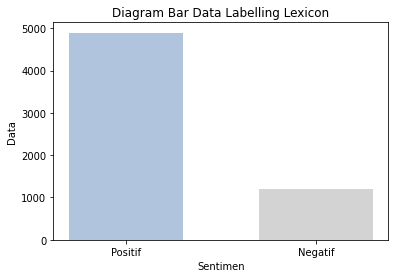

In [26]:
labels = ['Positif','Negatif']
Category1 = [4893, 1207]
plt.bar(labels, Category1, tick_label=labels, width=0.6, color=['lightsteelblue', 'lightgrey'])
plt.xlabel('Sentimen')
plt.ylabel('Data')
plt.title('Diagram Bar Data Labelling Lexicon')